In [ ]:
#This is a version 3 using t2-small language model to generate the questions with reinforce

In [ ]:
#!pip install torch
#!pip install tensorflow[and-cuda]
#!pip install --upgrade typing_extensions torch
#!pip install sentencepiece
#!pip install gym
#!pip install transformers

Episode 100, Avg Reward: 1.030, Win Rate: 3.0%
Episode 200, Avg Reward: 1.060, Win Rate: 6.0%
Episode 300, Avg Reward: 1.050, Win Rate: 5.0%
Episode 400, Avg Reward: 1.090, Win Rate: 9.0%
Episode 500, Avg Reward: 1.100, Win Rate: 10.0%
Episode 600, Avg Reward: 1.140, Win Rate: 14.0%
Episode 700, Avg Reward: 1.130, Win Rate: 13.0%
Episode 800, Avg Reward: 1.220, Win Rate: 22.0%
Episode 900, Avg Reward: 1.190, Win Rate: 19.0%
Episode 1000, Avg Reward: 1.230, Win Rate: 23.0%
Episode 1100, Avg Reward: 1.220, Win Rate: 22.0%
Episode 1200, Avg Reward: 1.310, Win Rate: 31.0%
Episode 1300, Avg Reward: 1.230, Win Rate: 23.0%
Episode 1400, Avg Reward: 1.250, Win Rate: 25.0%
Episode 1500, Avg Reward: 1.260, Win Rate: 26.0%
Episode 1600, Avg Reward: 1.230, Win Rate: 23.0%
Episode 1700, Avg Reward: 1.350, Win Rate: 35.0%
Episode 1800, Avg Reward: 1.320, Win Rate: 32.0%
Episode 1900, Avg Reward: 1.400, Win Rate: 40.0%
Episode 2000, Avg Reward: 1.370, Win Rate: 37.0%
Episode 2100, Avg Reward: 1.360, 

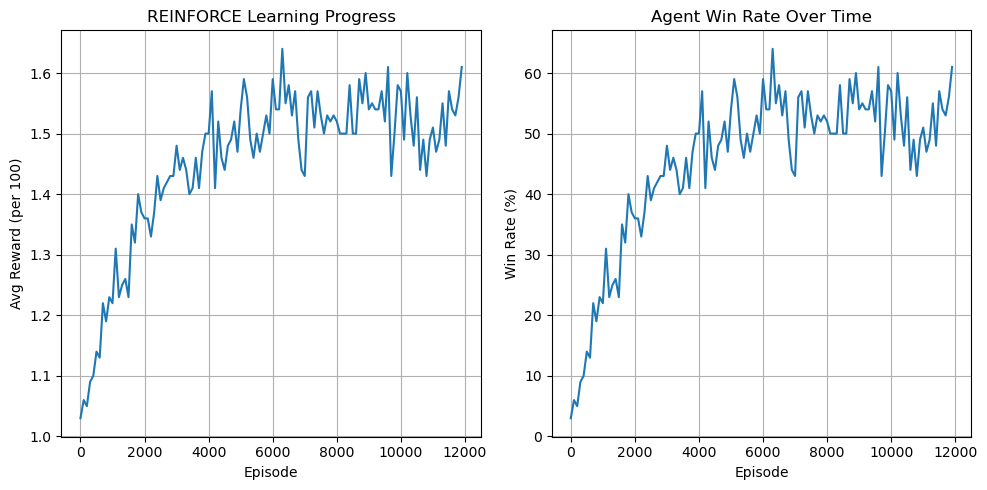

✅ Evaluation: 58/100 correct guesses → Win Rate: 58.0%
🤫 Target Animal: catfish
Q1: Predator: Predator: Predator: Predator → Yes
Q2: Generate a yes/no question about: Venomous → No
Q3: Generate a yes/no question about: Breathes → No
Q4: Generate a yes/no question about: Catsize: Cat → No
Q5: Generate a yes/no question about: Mammal → No
Q6: Generate a yes/no question about: Feathers → No
Q7: Generate a yes/no question about: Aquatic Aquatic → Yes
Q8: Generate a yes/no question about: Airborne → No
Q9: Generez une question "yes/no" about: Nleg → No
Q10: Generez une question "yes/no" about: Nleg → No
Q11: Generate a yes/no question about: Hair → No
Q12: Nlegs_2 → No
Q13: Generate a yes/no question about: Nlegs_ → No
Q14: Generate a yes/no question about: Domestic. → No
Q15: Gener → Yes
Q16: Generate a yes/no question about: Nlegs_ → Yes
Q17: Generate a yes/no question about: Reptile → No
Q18: Generate a yes/no question about: Toothed. → Yes
Q19: Generate a yes/no question about: Backbone

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from transformers import T5ForConditionalGeneration, T5Tokenizer

# --- Load Data ---
df = pd.read_excel('knowledge_base1.xlsx')
FEATURES = ["Hair", "Feathers", "Eggs", "Milk", "Airborne", "Aquatic", "Predator", "Toothed",
            "Backbone", "Breathes", "Venomous", "Fins", "Nlegs_0", "Nlegs_2", "Nlegs_4",
            "Nlegs_5", "Nlegs_6", "Nlegs_8", "Tail", "Domestic", "Catsize",
            "Mammal", "Bird", "Reptile", "Fish", "Amphibian", "Insect", "Invertebrate"]
NUM_ANIMALS = 100
NUM_FEATURES = len(FEATURES)
MAX_STEPS = 20

animal_names = df.iloc[:, 0].values
animal_features = df.iloc[:, 1:].values.astype(np.float32)

# --- T5-small Question Generator ---
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")

def generate_question(feature):
    prompt = f"Generate a yes/no question about: {feature}"
    input_ids = t5_tokenizer(prompt, return_tensors="pt").input_ids
    output_ids = t5_model.generate(input_ids, max_length=16)
    return t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)

# --- Policy Network ---
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(NUM_FEATURES, 128)
        self.fc2 = nn.Linear(128, NUM_FEATURES)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=-1)

# --- Guesser Network ---
class Guesser(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.log_softmax(self.fc2(x), dim=-1)

policy = PolicyNetwork()
guesser = Guesser(NUM_FEATURES, NUM_ANIMALS)
optimizer = optim.Adam(list(policy.parameters()) + list(guesser.parameters()), lr=1e-3)

# --- Training Episode ---
def play_episode(return_final_reward=False):
    target_idx = random.randint(0, NUM_ANIMALS - 1)
    target_features = animal_features[target_idx]
    
    state = torch.zeros(NUM_FEATURES)
    log_probs = []
    entropies = []
    asked = set()
    intermediate_reward = 0.0

    for _ in range(MAX_STEPS):
        probs = policy(state)
        mask = torch.ones_like(probs)
        mask[list(asked)] = 0
        masked_probs = probs * mask
        masked_probs = masked_probs / masked_probs.sum()

        dist = torch.distributions.Categorical(masked_probs)
        action = dist.sample()
        log_probs.append(dist.log_prob(action))
        entropies.append(dist.entropy())

        asked.add(action.item())
        new_state = state.clone().detach()
        new_state[action] = float(target_features[action])
        state = new_state

        if float(target_features[action]) == float(state[action]):
            intermediate_reward += 0.05

    # Use guesser network instead of dot-product
    guess_logits = guesser(state)
    predicted_idx = torch.argmax(guess_logits).item()
    final_reward = 1.0 if predicted_idx == target_idx else 0.0
    total_reward = intermediate_reward + final_reward
    entropy_sum = torch.stack(entropies).sum()

    # Guess loss
    guess_loss = F.nll_loss(guess_logits.unsqueeze(0), torch.tensor([target_idx]))
    return log_probs, total_reward, entropy_sum, final_reward, guess_loss

# --- Training Loop ---
def train(num_episodes=2000):
    rewards = []
    win_flags = []
    avg_rewards = []
    win_rates = []

    for episode in range(num_episodes):
        log_probs, reward, entropy, final_reward, guess_loss = play_episode(return_final_reward=True)

        baseline = np.mean(rewards[-100:]) if len(rewards) >= 100 else 0
        advantage = reward - baseline
        reinforce_loss = -sum(log_probs) * advantage - 0.01 * entropy
        loss = reinforce_loss + guess_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        rewards.append(reward)
        win_flags.append(final_reward)

        if (episode + 1) % 100 == 0:
            avg = np.mean(rewards[-100:])
            win_rate = np.mean(win_flags[-100:])
            avg_rewards.append(avg)
            win_rates.append(win_rate)
            print(f"Episode {episode+1}, Avg Reward: {avg:.3f}, Win Rate: {win_rate*100:.1f}%")

    # Plotting
    episodes = np.arange(len(avg_rewards)) * 100

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episodes, avg_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Avg Reward (per 100)")
    plt.title("REINFORCE Learning Progress")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(episodes, [w * 100 for w in win_rates])
    plt.xlabel("Episode")
    plt.ylabel("Win Rate (%)")
    plt.title("Agent Win Rate Over Time")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# --- Evaluation ---
def evaluate(num_games=100):
    wins = 0
    for _ in range(num_games):
        target_idx = random.randint(0, NUM_ANIMALS - 1)
        target_features = animal_features[target_idx]
        state = torch.zeros(NUM_FEATURES)
        asked = set()

        for _ in range(MAX_STEPS):
            probs = policy(state)
            mask = torch.ones_like(probs)
            mask[list(asked)] = 0
            masked_probs = probs * mask
            masked_probs = masked_probs / masked_probs.sum()

            action = torch.argmax(masked_probs).item()
            asked.add(action)
            state[action] = float(target_features[action])

        guess_logits = guesser(state)
        predicted_idx = torch.argmax(guess_logits).item()
        if predicted_idx == target_idx:
            wins += 1

    print(f"✅ Evaluation: {wins}/{num_games} correct guesses → Win Rate: {wins/num_games*100:.1f}%")

# --- Interactive Play ---
def play_game():
    with torch.no_grad():
        target_idx = random.randint(0, NUM_ANIMALS - 1)
        target_features = animal_features[target_idx]
        print("🤫 Target Animal:", animal_names[target_idx])
        
        state = torch.zeros(NUM_FEATURES)
        asked = set()

        for step in range(MAX_STEPS):
            probs = policy(state)
            mask = torch.ones_like(probs)
            mask[list(asked)] = 0
            masked_probs = probs * mask
            masked_probs = masked_probs / masked_probs.sum()

            action = torch.argmax(masked_probs).item()
            question = generate_question(FEATURES[action])
            answer = "Yes" if target_features[action] == 1 else "No"
            print(f"Q{step+1}: {question} → {answer}")

            state[action] = float(target_features[action])
            asked.add(action)

        guess_logits = guesser(state)
        predicted_idx = torch.argmax(guess_logits).item()
        print(f"🤖 Agent guesses: {animal_names[predicted_idx]}")

# --- Run Everything ---
train(num_episodes=12000)
evaluate(num_games=100)
play_game()
